# Arithmetic circuits

<a id='contents'></a>
## Contents

* [Setup](#setup)
* [Introduction](#introduction)
* [Modeling computations](#definition)
* [Topological ordering](#topological_ordering)
* [Gate-value functions](#gate_values)
* [Wiring predicates](#wiring_predicates)
* [Thaler's identity](#thaler_identity)
* [Conclusion](#conclusion)
* [References](#references)
* [Appendix A: further examples](#appendix_a)
* [Appendix B: graph theory](#appendix_b)

<a id='setup'></a>
## Setup
↑↑ [Contents](#contents) ↓ [Introduction](#introduction)

In [1]:
from pathlib import Path
import os
import sys

# To use this project, set an environment variable named "ZERO_KNOWLEDGE" on your system
# Determine the project root directory and add it to the Python path
notebook_path = Path(os.getcwd()).resolve()  # Path to the current working directory
project_root = notebook_path.parent          # Parent directory of notebooks, which is the project root

# Add the project root directory to the Python path
sys.path.append(str(project_root))

# The setup module is project_root/scripts/setup.py
from scripts.setup import *


PROJECT DIRECTORY TREE AS AT 2025-01-20 10:27:04

BASE PATH: F:\PROJECTS\INFERENCE-LABS\ZK-NOTEBOOKS

├─ assets/
├─ notebooks/
│  └─ 01-sum-check-protocol.ipynb
│  └─ 02-multilinear-extensions.ipynb
│  └─ 03-arithmetic-circuits.ipynb
│  └─ 04-gkr-protocol.ipynb
│  └─ 2025-01-20-sprint-retro-demo.ipynb
├─ scripts/
│  └─ arithmetic_circuits.py
│  └─ gkr_protocol.py
│  └─ info.py
│  └─ multilinear_extensions.py
│  └─ setup.py
│  └─ sum_check.py
│  └─ utils.py
└─ .gitignore
└─ LICENSE
└─ README.md
└─ requirements.txt

PATHS TO FIRST-LEVEL SUBDIRECTORIES STORED IN 'PATH' DICTIONARY

├─ path['scripts'] = F:\projects\inference-labs\zk-notebooks\scripts
├─ path['notebooks'] = F:\projects\inference-labs\zk-notebooks\notebooks
├─ path['circuits'] = F:\projects\inference-labs\zk-notebooks\circuits
├─ path['assets'] = F:\projects\inference-labs\zk-notebooks\assets


<a id='introduction'></a>
## Introduction
↑↑ [Contents](#contents) ↑ [Setup](#setup) ↓ [Definition](#definition)

Through our [sum-check protocol](./01-sum-check-protocol) and [multilinear extensions](./02-multilinear-extensions) notebooks, we have started to replicate Thaler's elegant presentation [[THA2015]](#tha2015) of the GKR interactive proof for circuit evaluation, as introduced by Goldwasser, Kalai, and Rothblum [[GKR2008]](#gkr2008). We are nearly ready to present the GKR protocol in full, but before we do, there's one final topic to address: arithmetic circuits.

<a id='definition'></a>
## Modeling computations
↑↑ [Contents](#contents) ↑ [Introduction](#introduction) ↓ [Topological ordering](#topological_ordering)

An arithmetic circuit is defined as a special kind of directed graph, which is assumed to be familiar to the reader. For the necessary definitions and relevant results in graph theory, refer to [Appendix B: graph theory](#appendix_b).

**Definition [arithmetic circuit].** An _arithmetic circuit_ $C$ over a field $\mathbb{F}$ in the variables $X = \{x_0, \ldots, x_{n-1}\}$ is a labeled directed acyclic multigraph (DAG). The nodes of this graph are called _gates_, and the edges are called _wires_.

- _Input gates_ are gates with _fan-in_ (in-degree) zero, labeled by variables from $X$ or constants from $\mathbb{F}$.
  
- _Output gates_ are gates with _fan-out_ (out-degree) zero, where the output of the circuit is computed.

- _Non-input gates_ are either _addition gates_, labeled with the addition operation ($+$), or _multiplication gates_, labeled with the multiplication operation ($\times$). These gates compute the sum or product of the polynomials computed on the tails of the incoming wires. Subtraction can be represented by multiplication with the constant $-1$ (i.e., using $(x - y) = x + (-1) \cdot y$).

* The _output_ of $C$ is the polynomial (or set of polynomials) computed at the output gate(s).

* The _size_ $S$ of $C$ is the total number of gates in the graph, and the _depth_ $d$ of $C$ is the length of the longest path from an input gate to an output gate.

* Layer $i$ of $C$ is a set of all gates $v$ such that the shortest path from $v$ to any output gate has length $i$.

We say that $C$ is a _constant-input_ circuit if:

* Every input gate is labeled with a constant from $\mathbb{F}$ (as opposed to a variable from $X$).

We say that $C$ is a _binary_ arithmetic circuit if:

* Every non-input gate has a fan-in of $2$, representing a _binary_ operation on two inputs.

We say that $C$ is a _strictly layered_ arithmetic circuit if:

* All inputs are in Layer $d$, and every wire is a wire from a gate in layer $i + 1$ to a gate in layer $i$, for some $i \in \{0,1,\ldots,d - 1\}$, where $d$ is the depth of the circuit.

---

**Assumption.** Throughout, we will assume that all of our arithmetic circuits are **constant-input**, **binary** and **strictly layered**. 

---

**Example.** Consider evaluating the expressions $(2 + 2) \times (3 \times 3)$ and $3 \times 4 + (5 + 5)$ in the field $\mathbb{F} = \mathbb{Z}/11\mathbb{Z}$. The following circuit of size $S = 10$ and depth $d = 2$ illustrates one way to perform this computation:

- **Layer 0 (output layer)**: The top layer contains the two gates labeled $\times$ and $+$.
- **Layer 1 (intermediate layer)**: The middle layer contains four gates labeled $+$, $\times$, $\times$, and $+$.
- **Layer 2 (input layer)**: The bottom layer contains four gates labeled $2$, $3$, $4$, and $5$.

In this structure:
- Every input gate is labeled with a constant from $\mathbb{F}$. This is a constant-input circuit.
- Every gate in layers 0 and 1 has a fan-in of $2$ (representing a binary operation, either addition or multiplication). This is a binary circuit.
- All inputs are in Layer 2: no inputs are in Layer 0 or Layer 1. Also, wires only connect consecutive layers: from Layer 2 to Layer 1, and from Layer 1 to Layer 0. No wires connect gates within the same layer, non-consecutive layers, or consecutive layers in the 'low to high' (e.g. 1 to 2) direction. This is a strictly layered circuit.

For example:
- The two wires from the gate labeled $2$ enter the leftmost gate in Layer 1 labeled $+$, representing the subexpression $2 + 2$.
- Similarly, the gates in Layer 1 compute the subexpressions $3 \times 3$, $3 \times 4$, and $5 + 5$ in parallel. The number $3$ appears three times in the circuit because it is reused in both $3 \times 3$ and $3 \times 4$, avoiding duplicate inputs.

Next, in Layer 1, we evaluate:
- $2 + 2 \equiv 4 \bmod 11$,
- $3 \times 3 \equiv 9 \bmod 11$,
- $3 \times 4 \equiv 1 \bmod 11$,
- $5 + 5 \equiv 10 \bmod 11$.

Finally, the output layer computes:
- $4 \times 9 \equiv 3 \bmod 11$,
- $1 + 10 \equiv 0 \bmod 11$.

Thus, the circuit computes two expressions through six binary operations performed in two stages, holding four field elements in memory at each stage.

(2 + 2)*(3*3) mod 11, 3*4 + (5 + 5) mod 11


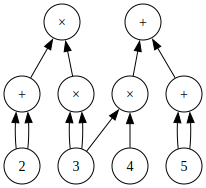

This circuit has size S = 10 and depth d = 2.


In [2]:
from arithmetic_circuits import ArithmeticCircuit

expression_01a = '(2 + 2)*(3*3)'
expression_01b = '3*4 + (5 + 5)'

ac_01 = ArithmeticCircuit(expression_01a, expression_01b, prime=11)
print(f"{expression_01a} mod {ac_01.field.mod}, {expression_01b} mod {ac_01.field.mod}")
display(ac_01.graphviz_circuit)

print(f"This circuit has size S = {ac_01.size} and depth d = {ac_01.depth}.")

<a id='topological_ordering'></a>
## Topological ordering
↑↑ [Contents](#contents) ↑ [Modeling computations](#definition) ↓ [Gate-value functions](#gate_values)

An arithmetic circuit cannot have cycles because it represents a well-defined, finite computation. They are designed to compute polynomials in a finite number of steps. If a cycle existed, it would be unclear where to start, and the computation would never terminate. For example, the cycle below results in the expression $2 + (3 \times (2 + ( 3 \times \cdots )))$ (or $3 \times (2 + (3 \times ( 2 + \cdots )))$), which is ambiguous and infinite, making it meaningless. Arithmetic circuits are acyclic to ensure that each operation is performed in a clear, finite sequence.

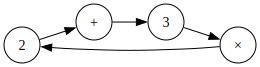

In [3]:
from graphviz import Digraph

# Non-DAG example
dot = Digraph()
dot.node('2', '2', shape='circle')
dot.node('+', '+', shape='circle')
dot.node('3', '3', shape='circle')
dot.node('×', '×', shape='circle') 
dot.edge('2', '+')
dot.edge('+', '3')
dot.edge('3', '×') 
dot.edge('×', '2')
dot.attr(rankdir='LR')
display(dot)

A _topological ordering_ (or _topological sort_) of a directed graph is a linear ordering of its vertices such that, for every directed edge from vertex $u$ to vertex $v$, vertex $u$ appears before vertex $v$ in the ordering. In other words, the ordering respects the direction of the edges.

More formally:

**Definition [topological ordering].** Given a directed acyclic graph (DAG) $ G = (V, E) $, a _topological ordering_ of the vertices $V$ is a linear sequence $v_0, v_1, \ldots, v_{n-1}$ such that for every directed edge $(v_i, v_j) \in E$, it holds that $i < j$, meaning that vertex $v_i$ appears before vertex $v_j$ in the ordering.

---

Since an arithmetic circuit is acyclic, a _topological order_ of its nodes allows us to evaluate the circuit in a sequence where each node (operation) depends only on previously evaluated nodes. This ensures that each computation is performed in a clear, finite order, starting from the input nodes and progressing through intermediate gates to the output nodes. Without a valid topological order, cycles would create circular dependencies, preventing the circuit from being evaluated at all. Therefore, topological ordering guarantees that the computation proceeds in a finite, unambiguous manner.

**Example.**

Continuing with the previous example, we assign each node a unique label based on its layer. Let $S_i$ denote the number of gates in layer $i$, and number the gates from $0$ to $S_i - 1$ (without any specific ordering), using binary representation for reasons that will become clear shortly. We then prefix each binary string with `i.` to differentiate between layers. Below is a topological ordering.

{0: {'0.0', '0.1'},
 1: {'1.00', '1.01', '1.10', '1.11'},
 2: {'2.00', '2.01', '2.10', '2.11'}}

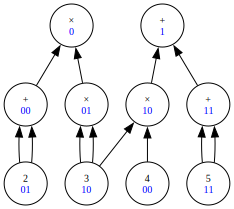


TOPOLOGICAL ORDERING

2.01 -> 2.10 -> 2.00 -> 2.11 -> 1.00 -> 1.01 -> 1.10 -> 1.11 -> 0.0 -> 0.1


In [4]:
display(ac_01.layers)
print("")
display(ac_01.graphviz_circuit_bitstring)
print("")
ac_01.print_topological_order()

<a id='gate_values'></a>
## Gate-value functions
↑↑ [Contents](#contents) ↑ [Topological ordering](#topological_ordering) ↓ [Wiring predicates](#wiring_predicates)

**Definition [layer size, bit length, and bit labeling].**  Let $C$ be an arithmetic circuit of depth $d$. For $0 \le i \le d$, let $S_i$ denote the number of gates in Layer $i$, and let $s_i$ be the smallest integer such that $S_i \leq 2^{s_i}$. We refer to $S_i$ as the _size_ of Layer $i$, and $s_i$ as the _bit length_ of Layer $i$. A _bit labeling_ of the gates in Layer $i$ assigns each gate a unique bitstring of length $s_i$, corresponding to the binary representation of its index in the layer. If $\mathbf{b} \in \{0,1\}^{s_i}$, we refer to the gate in Layer $i$ labeled by $\mathbf{b}$ as _gate $\mathbf{b}$_.

---

**Remark.** In the degenerate case where $S_i = 1$ and $s_i = 0$, a bit labeling assigns the only gate, which has index $0$, to the empty string $()$. This will be the case in Layer $0$ of a circuit with a single output. More formally, a bit labeling is a map $\ell : \{0, \ldots, S_i - 1\} \to \{0,1\}^{s_i}$. When $S_i = 1$ and $s_i = 0$, we interpret $\{0,1\}^{s_i}$ as the singleton set whose only element is the empty set. In this case, $\ell : \{0\} \to \{\emptyset\}$ maps $0$ to $\ell(0) = \emptyset$, which we represent as $()$. 

**Definition [gate-value function].** Let $C$ be a constant-input, binary, strictly layered arithmetic circuit of depth $d$ over a field $\mathbb{F}$. For $0 \leq i \leq d$, let Layer $i$ have size $S_i$ and bit length $s_i$, and fix a bit labeling of each layer. The **gate-value function** $W_i : \{0,1\}^{s_i} \to \mathbb{F}$ is defined as follows:

1. **Non-gate labels:** If $\mathbf{b} \in \{0,1\}^{s_i}$ does not correspond to a valid gate label in Layer $i$ (i.e., if $S_i$ is not a power of 2 and $\mathbf{b}$ represents an integer exceeding $S_i - 1$), then:  
\begin{equation*}
W_i(\mathbf{b}) := 0.
\end{equation*}

3. **Valid gate labels:**  

   - **Layer $d$ (input layer):** For all $\mathbf{b} \in \{0,1\}^{s_d}$, define:  
     \begin{equation*}
     W_d(\mathbf{b}) := \text{the input at gate $\mathbf{b}$ in Layer $d$}.
     \end{equation*}

   - **Intermediate layers, $d-1 \geq i \geq 0$:** For $\mathbf{c} \in \{0,1\}^{s_i}$, let $\mathbf{a}, \mathbf{b} \in \{0,1\}^{s_{i+1}}$ (possibly $\mathbf{a} = \mathbf{b}$) be the gates in Layer $i+1$ connected by wires to gate $\mathbf{c}$. Define:  
     \begin{equation*}
     W_i(\mathbf{c}) := W_{i+1}(\mathbf{a}) \odot W_{i+1}(\mathbf{b}),
     \end{equation*}
     where $\odot$ represents:  
     - Addition, if gate $\mathbf{c}$ is an addition gate;  
     - Multiplication, if gate $\mathbf{c}$ is a multiplication gate.

4. **Multilinear extension:** For each layer $i$, the **multilinear extension** $\widetilde{W}_i : \mathbb{F}^{s_i} \to \mathbb{F}$ is defined to extend $W_i$ to inputs in $\mathbb{F}^{s_i}$.

---

**Example.**

Continuing with our previous example, we have layer sizes $S_2 = S_1 = 4$ and $S_0 = 2$; we have layer bit lengths $s_2 = s_1 = 2$ and $s_0 = 1$. Hence, we can write: 
\begin{align*} 
W_2 & : \{0,1\}^2 \to \mathbb{F}, \quad && \widetilde{W}_2 : \mathbb{F}^2 \to \mathbb{F}, \\ 
W_1 & : \{0,1\}^2 \to \mathbb{F}, \quad && \widetilde{W}_1 : \mathbb{F}^2 \to \mathbb{F}, \\ 
W_0 & : \{0,1\} \to \mathbb{F}, \quad && \widetilde{W}_0 : \mathbb{F} \to \mathbb{F}. 
\end{align*} 
In Layer $i$, $i \in \{0,1,2\}$, we label the gates from $0$ to $S_i - 1$ using a bitstring of length $s_i$. The specific ordering within each layer is not defined here, but it is important to note that any changes in the ordering within layer $i + 1$ can affect $W_{i + 1}$ and its corresponding multilinear extension. This effect will propagate to $W_{i}$, and so on.

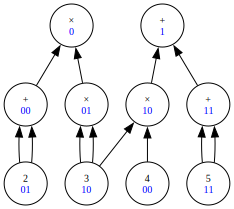

In [5]:
display(ac_01.graphviz_circuit_bitstring)

In [6]:
ac_01.print_gate_values()

GATE VALUES

LAYER 2

W_2(0,0) = 4
W_2(0,1) = 2
W_2(1,0) = 3
W_2(1,1) = 5

LAYER 1

W_1(0,0) = 4
W_1(0,1) = 9
W_1(1,0) = 1
W_1(1,1) = 10

LAYER 0

W_0(0) = 3
W_0(1) = 0



In [7]:
ac_01.print_tilde_W()

MULTLINEAR EXTENSIONS OF GATE-VALUE FUNCTIONS

LAYER 2

W̃_2(x_0, x_1) = 4*x_0*x_1 + 10*x_0 + 9*x_1 + 4

LAYER 1

W̃_1(x_0, x_1) = 4*x_0*x_1 + 8*x_0 + 5*x_1 + 4

LAYER 0

W̃_0(x_0) = 8*x_0 + 3



<a id='wiring_predicates'></a>
## Wiring predicates
↑↑ [Contents](#contents) ↑ [Gate-value functions](#gate_values) ↓ [Thaler's identity](#thaler_identity)

**Definition [wiring predicates].** Let $C$ be a binary, strictly layered arithmetic circuit of depth $d$ over a field $\mathbb{F}$. For $0 \leq i \leq d$, let Layer $i$ have size $S_i$ and bit length $s_i$, and fix a bit labeling of each layer. For $0 \le i \le d - 1$, the _wiring predicates_ 
\begin{align*}
\mathrm{add}_i & : \{0,1\}^{s_i} \times \{0,1\}^{s_{i + 1}} \times \{0,1\}^{s_{i + 1}} \to \mathbb{F} \\
\mathrm{mult}_i & : \{0,1\}^{s_i} \times \{0,1\}^{s_{i + 1}} \times \{0,1\}^{s_{i + 1}} \to \mathbb{F}
\end{align*}
with respect to this bit labeling is defined as follows. Let $\mathbf{c} \in \{0,1\}^{s_i}$, and let $\mathbf{a}, \mathbf{b} \in \{0,1\}^{s_{i + 1}}$ be gates in layer $i + 1$ (with the possibility that $\mathbf{a} = \mathbf{b}$).
* If gate $\mathbf{c}$ is an addition gate and is connected to gates $\mathbf{a}$ and $\mathbf{b}$, then we set $\mathrm{add}_i(\mathbf{c}, \mathbf{a}, \mathbf{b}) = 1$; otherwise, we set $\mathrm{add}_i(\mathbf{c}, \mathbf{a}, \mathbf{b}) = 0$.
* If gate $\mathbf{c}$ is a multiplication gate and is connected to gates $\mathbf{a}$ and $\mathbf{b}$, then we set $\mathrm{mult}_i(\mathbf{c}, \mathbf{a}, \mathbf{b}) = 1$; otherwise, we set $\mathrm{mult}_i(\mathbf{c}, \mathbf{a}, \mathbf{b}) = 0$.
* If $\mathbf{c}$ is the label of a nonexistent gate, i.e., $S_i$ is not a power of $2$ and $\mathbf{c}$ is the binary representation of an integer exceeding $S_i - 1$, $\mathrm{add}_i(\mathbf{c}, \mathbf{a}, \mathbf{b}) = \mathrm{mult}_i(\mathbf{c}, \mathbf{a}, \mathbf{b}) = 0$.

We may then define the multilinear extensions
\begin{align*}
\widetilde{\mathrm{add}}_i & : \mathbb{F}^{s_i} \times \mathbb{F}^{s_{i + 1}} \times \mathbb{F}^{s_{i + 1}} \to \mathbb{F} \\
\widetilde{\mathrm{mult}}_i & : \mathbb{F}^{s_i} \times \mathbb{F}^{s_{i + 1}} \times \mathbb{F}^{s_{i + 1}} \to \mathbb{F}
\end{align*}

---
For $A \subseteq \mathbb{F}$, we may of course identify the domain $A^{s_i} \times A^{s_{i + 1}} \times A^{s_{i + 1}}$ with $A^{s_i + 2s_{i + 1}}$, and write $(c_0,\ldots,c_{s_i - 1},a_0,\ldots,a_{s_{i + 1} - 1},b_0,\ldots,b_{s_{i + 1} - 1})$ instead of $((c_0,\ldots,c_{s_i - 1}),(a_0,\ldots,a_{s_{i + 1} - 1}),(b_0,\ldots,b_{s_{i + 1} - 1}))$ for the input of $\mathrm{add}_i$ and $\mathrm{mult}_i$.

**Example.**

In our example:
\begin{align*}
 \mathrm{add}_0 & : \{0,1\}^{1} \times \{0,1\}^{2} \times \{0,1\}^{2} \to \mathbb{F} \\
 \mathrm{mult}_0 & : \{0,1\}^{1} \times \{0,1\}^{2} \times \{0,1\}^{2} \to \mathbb{F}
\end{align*}


\begin{align*}
 \mathrm{add}_1 & : \{0,1\}^{2} \times \{0,1\}^{2} \times \{0,1\}^{2} \to \mathbb{F} \\
 \mathrm{mult}_1 & : \{0,1\}^{2} \times \{0,1\}^{2} \times \{0,1\}^{2} \to \mathbb{F}
\end{align*}

\begin{align*}
 \widetilde{\mathrm{add}}_0 & : \mathbb{F}^{1} \times \mathbb{F}^{2} \times \mathbb{F}^{2} \to \mathbb{F} \\
 \widetilde{\mathrm{mult}}_0 & : \mathbb{F}^{1} \times \mathbb{F}^{2} \times \mathbb{F}^{2} \to \mathbb{F}
\end{align*}

\begin{align*}
 \widetilde{\mathrm{add}}_1 & : \mathbb{F}^{2} \times \mathbb{F}^{2} \times \mathbb{F}^{2} \to \mathbb{F} \\
 \widetilde{\mathrm{mult}}_1 & : \mathbb{F}^{2} \times \mathbb{F}^{2} \times \mathbb{F}^{2} \to \mathbb{F}
\end{align*}



In [8]:
ac_01.print_wiring_predicates()

ADDITION WIRING PREDICATES (NONZERO VALUES)

LAYER 1

add_1(0,0,0,1,0,1) = 1
add_1(1,1,1,1,1,1) = 1

LAYER 0

add_0(1,1,0,1,1) = 1

MULTIPLICATION WIRING PREDICATES (NONZERO VALUES)

LAYER 1

mult_1(0,1,1,0,1,0) = 1
mult_1(1,0,1,0,0,0) = 1

LAYER 0

mult_0(0,0,0,0,1) = 1



In [9]:
ac_01.print_wiring_predicate_mles()

MULTLINEAR EXTENSIONS OF WIRING PREDICATES: ADD

LAYER 1

add̃_1(z_0,z_1,x_0,x_1,y_0,y_1) = 2*x_0*x_1*y_0*y_1*z_0*z_1 + 10*x_0*x_1*y_0*y_1*z_0 + 10*x_0*x_1*y_0*y_1*z_1 + x_0*x_1*y_0*y_1 + 10*x_0*x_1*y_1*z_0*z_1 + x_0*x_1*y_1*z_0 + x_0*x_1*y_1*z_1 + 10*x_0*x_1*y_1 + 10*x_1*y_0*y_1*z_0*z_1 + x_1*y_0*y_1*z_0 + x_1*y_0*y_1*z_1 + 10*x_1*y_0*y_1 + x_1*y_1*z_0*z_1 + 10*x_1*y_1*z_0 + 10*x_1*y_1*z_1 + x_1*y_1

LAYER 0

add̃_0(z_0,x_0,x_1,y_0,y_1) = 10*x_0*x_1*y_0*y_1*z_0 + x_0*y_0*y_1*z_0

MULTLINEAR EXTENSIONS OF WIRING PREDICATES: MULT

LAYER 1

mult̃_1(z_0,z_1,x_0,x_1,y_0,y_1) = 10*x_0*x_1*y_0*y_1*z_0 + x_0*x_1*y_0*y_1*z_1 + x_0*x_1*y_0*z_0 + 10*x_0*x_1*y_0*z_1 + 10*x_0*x_1*y_1*z_0*z_1 + x_0*x_1*y_1*z_0 + x_0*x_1*z_0*z_1 + 10*x_0*x_1*z_0 + x_0*y_0*y_1*z_0 + 10*x_0*y_0*y_1*z_1 + 10*x_0*y_0*z_0 + x_0*y_0*z_1 + x_0*y_1*z_0*z_1 + 10*x_0*y_1*z_0 + 10*x_0*z_0*z_1 + x_0*z_0

LAYER 0

mult̃_0(z_0,x_0,x_1,y_0,y_1) = x_0*x_1*y_0*y_1*z_0 + 10*x_0*x_1*y_0*y_1 + 10*x_0*x_1*y_1*z_0 + x_0*x_1*y_1 + 10*x_0*

<a id='thaler_identity'></a>
## Thaler's identity
↑↑ [Contents](#contents) ↑ [Wiring predicates](#wiring) ↓ [Conclusion](#conclusion)

The structure of an arithmetic circuit is fully described by the wiring predicates $\mathrm{add}_i$ and $\mathrm{mult}_i$, which encode its topology but not the values assigned to the gates by the gate-value functions $W_i$. The circuit's computation can be expressed in terms of the gate-value functions and wiring predicates, as shown in part (a) of the following proposition. Part (b) enables us to apply the sum-check protocol to verify the output of a circuit, as we will explore in the [next notebook](./04-gkr-protocol). We refer to this as Thaler's identity, a simplification by Thaler [[THA2015]](#tha2015) of an identity of Cormode, Mitzenmacher, and Thaler [[CMT2012]](#cmt2012).

**Proposition.** Let $C$ be a constant-input, binary, strictly layered arithmetic circuit of depth $d$ over a field $\mathbb{F}$. For $0 \leq i \leq d$, let Layer $i$ have size $S_i$ and bit length $s_i$, and fix a bit labeling of each layer. For $0 \le i \le d$, let $W_i$ be the gate-value function corresponding to this bit labeling, and for $0 \le i \le d - 1$, let $\mathrm{add}_i$ and $\mathrm{mult}_i$ be the wiring predicates corresponding to this bit labeling.

(a) **[Layer-wise gate-value propagation equation]** Let $i \in \{0,\ldots,d - 1\}$. For all $\mathbf{z} \in \{0,1\}^{s_i}$,

\begin{equation}
W_i(\mathbf{z}) = 
\sum_{\substack{\mathbf{x} \, \in \{0,1\}^{s_{i + 1}} \\ \mathbf{y} \, \in \{0,1\}^{s_{i + 1}}}} \Big\{ \mathrm{add}_i(\mathbf{z},\mathbf{x},\mathbf{y}) \big[ W_{i+1}(\mathbf{x}) + W_{i+1}(\mathbf{y})\big]
 + \mathrm{mult}_i(\mathbf{z},\mathbf{x},\mathbf{y}) \big[ W_{i+1}(\mathbf{x})W_{i+1}(\mathbf{y})\big]\Big\}. \tag{1}
\end{equation}

(b) **[Thaler's identity]** Let $i \in \{0,\ldots,d - 1\}$. For all $\mathbf{z} \in \mathbb{F}^{s_i}$,

\begin{equation}
\tag{2}
\widetilde{W}_i(\mathbf{z}) = \sum_{\substack{\mathbf{x} \, \in \{0,1\}^{s_{i + 1}} \\ \mathbf{y} \, \in \{0,1\}^{s_{i + 1}}}} \Big\{\widetilde{\mathrm{add}}_i(\mathbf{z},\mathbf{x},\mathbf{y}) \big[ \widetilde{W}_{i + 1}(\mathbf{x}) + \widetilde{W}_{i + 1}(\mathbf{y})\big]
 + \widetilde{\mathrm{mult}}_i(\mathbf{z},\mathbf{x},\mathbf{y}) \big[ \widetilde{W}_{i + 1}(\mathbf{x})\widetilde{W}_{i + 1}(\mathbf{y})\big]\Big\}.
\end{equation}

_Proof._ (a) Let $\mathbf{z} \in \{0,1\}^{s_i}$. When gate $\mathbf{z}$ is connected to gates $\mathbf{a}$ and $\mathbf{b}$, the only potentially nonzero summand on the right-hand side of $(1)$ corresponds to $\mathbf{x} = \mathbf{a}$ and $\mathbf{y} = \mathbf{b}$. Furthermore:

- If $\mathbf{z}$ is an addition gate, then $\mathrm{mult}_i(\mathbf{z},\mathbf{a},\mathbf{b}) = 0$, reducing the right-hand side to

\begin{equation*}
\mathrm{add}_i(\mathbf{z},\mathbf{a},\mathbf{b})\big[ W_{i+1}(\mathbf{a}) + W_{i+1}(\mathbf{b})\big] = W_{i+1}(\mathbf{a}) + W_{i+1}(\mathbf{b}) = W_i(\mathbf{z}).
\end{equation*}

- Similarly, if $\mathbf{z}$ is a multiplication gate, then $\mathrm{add}_i(\mathbf{z},\mathbf{a},\mathbf{b}) = 0$, reducing the right-hand side to

\begin{equation*}
\mathrm{mult}_i(\mathbf{z},\mathbf{a},\mathbf{b})\big[ W_{i+1}(\mathbf{a}) W_{i+1}(\mathbf{b})\big] = W_{i+1}(\mathbf{a}) W_{i+1}(\mathbf{b}) = W_i(\mathbf{z}).
\end{equation*}

(b) Still assuming $\mathbf{z} \in \{0,1\}^{s_i}$, since $\mathbf{z}$, $\mathbf{x}$, and $\mathbf{y}$ lie in a Boolean hypercube, each function in the expression $(1)$ can be replaced by its multilinear extension. Specifically, for $\mathbf{z} \in \{0,1\}^{s_i}$,

\begin{equation*}
W_i(\mathbf{z}) = \widetilde{W}_i(\mathbf{z}); \tag{3}
\end{equation*}

for $\mathbf{x}, \mathbf{y} \in \{0,1\}^{s_{i + 1}}$,

\begin{equation*}
W_{i + 1}(\mathbf{x}) = \widetilde{W}_{i + 1}(\mathbf{x}) \quad \text{and} \quad W_{i + 1}(\mathbf{y}) = \widetilde{W}_{i + 1}(\mathbf{y});
\end{equation*}

and for $(\mathbf{z},\mathbf{x}, \mathbf{y}) \in \{0,1\}^{s_i} \times \{0,1\}^{s_{i + 1}} \times \{0,1\}^{s_{i + 1}}$,

\begin{equation*}
\mathrm{add}_i(\mathbf{z},\mathbf{x},\mathbf{y}) = \widetilde{\mathrm{add}}_i(\mathbf{z},\mathbf{x},\mathbf{y}) \quad \text{and} \quad
\mathrm{mult}_i(\mathbf{z},\mathbf{x},\mathbf{y}) = \widetilde{\mathrm{mult}}_i(\mathbf{z},\mathbf{x},\mathbf{y}).
\end{equation*}

Therefore,

\begin{align*}
\tag{4}
\begin{split} 
& \sum_{\substack{\mathbf{x} \, \in \{0,1\}^{s_{i + 1}} \\ \mathbf{y} \, \in \{0,1\}^{s_{i + 1}}}} \Big\{ \mathrm{add}_i(\mathbf{z},\mathbf{x},\mathbf{y}) \big[ W_{i+1}(\mathbf{x}) + W_{i+1}(\mathbf{y})\big]
 + \mathrm{mult}_i(\mathbf{z},\mathbf{x},\mathbf{y}) \big[ W_{i+1}(\mathbf{x})W_{i+1}(\mathbf{y})\big]\Big\}
  \\ & =
\sum_{\substack{\mathbf{x} \, \in \{0,1\}^{s_{i + 1}} \\ \mathbf{y} \, \in \{0,1\}^{s_{i + 1}}}} \Big\{\widetilde{\mathrm{add}}_i(\mathbf{z},\mathbf{x},\mathbf{y}) \big[ \widetilde{W}_{i + 1}(\mathbf{x}) + \widetilde{W}_{i + 1}(\mathbf{y})\big]
 + \widetilde{\mathrm{mult}}_i(\mathbf{z},\mathbf{x},\mathbf{y}) \big[ \widetilde{W}_{i + 1}(\mathbf{x})\widetilde{W}_{i + 1}(\mathbf{y})\big]\Big\}.
 \end{split}
\end{align*}

The functions on both sides of $(2)$ are defined for all $\mathbf{z} \in \mathbb{F}^{s_i}$, and we've just shown they agree for all $\mathbf{z}$ in the Boolean hypercube $\{0,1\}^{s_i}$. We claim that equality in fact holds for all $\mathbf{z}$ in $\mathbb{F}^{s_i}$. Since the left-hand side is a multilinear extension of $W_i$ and the right hand side is an extension of $W_i$, it suffices to show that the right-hand side is _multlinear_ in $\mathbf{z}$. By uniqueness of multilinear extensions, it then follows that both sides of $(2)$ are the same function on $\mathbb{F}^{s_i}$, viz. the multilinear extension of $W_i$. 

Indeed, given $\mathbf{x}, \mathbf{y} \in \{0,1\}^{s_{i + 1}}$, $\widetilde{\mathrm{add}}_i(\mathbf{z},\mathbf{x},\mathbf{y})$ and $\widetilde{\mathrm{mult}}_i(\mathbf{z},\mathbf{x},\mathbf{y})$ are multilinear functions in $\mathbf{z}$, because they are multinear extensions of $\mathrm{add}_i$ and $\mathrm{mult}_i$ respectively. Recall the [proposition](./02-multilinear-extensions#mle_proposition) of our [multilinear extensions notebook](./02-multilinear-extensions), which states that the multilinear extension process is linear on function spaces, i.e. $\widetilde{cf + dg} = c\tilde{f} + d\tilde{g}$. This implies that the summand on the right-hand side of $(2)$ is a multilinear function in $\mathbf{z}$, and therefore, in turn, that the entire sum is a multilinear function in $\mathbf{z}$.

**Remark.** (i) We call a function multilinear if it is the evaluation map of some multilinear polynomial. For example, over $\mathbb{Z}/3\mathbb{Z}$, the function $(z_0,z_1,x_0,x_1,y_0,y_1) \mapsto x_0^2y_1z_0^3 + x_1y_0^2z_1^3$ is multilinear in $(z_0,z_1)$, because it is equivalent to the function $(z_0,z_1,x_0,x_1,y_0,y_1) \mapsto x_0^2y_1z_0 + x_1y_0^2z_2$, which is the evaluation map of the multilinear polynomail $X_0^2Y_1Z_0 + X_1Y_0^2Z_1$. (ii) We did not use the fact that $\widetilde{\mathrm{add}}_i(\mathbf{z},\mathbf{x},\mathbf{y})$ and $\widetilde{\mathrm{mult}}_i(\mathbf{z},\mathbf{x},\mathbf{y})$ are multilinear functions with respect to $\mathbf{x}$ and $\mathbf{y}$ in the above proof. The hypotheses for Thaler's identity can be relaxed: $\widetilde{\mathrm{add}}_i(\mathbf{z},\mathbf{x},\mathbf{y})$ and $\widetilde{\mathrm{mult}}_i(\mathbf{z},\mathbf{x},\mathbf{y})$ can be extensions of $\mathrm{add}_i(\mathbf{z},\mathbf{x},\mathbf{y})$ and $\mathrm{mult}_i(\mathbf{z},\mathbf{x},\mathbf{y})$ that are multilinear in $\mathbf{z}$. 

In [10]:
ac_01.print_verification_propagation_equation()

VERIFICATION OF LAYER-WISE GATE-VALUE PROPAGATION EQUATION

LAYER 1

W_1(0,0) = 4, sum { add_1((0,0),x,y) [ W_2(x) + W_2(y) ] + mult_1(0,0,x,y) [ W_2(x) W_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 4 ✓
W_1(0,1) = 9, sum { add_1((0,1),x,y) [ W_2(x) + W_2(y) ] + mult_1(0,1,x,y) [ W_2(x) W_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 9 ✓
W_1(1,0) = 1, sum { add_1((1,0),x,y) [ W_2(x) + W_2(y) ] + mult_1(1,0,x,y) [ W_2(x) W_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 1 ✓
W_1(1,1) = 10, sum { add_1((1,1),x,y) [ W_2(x) + W_2(y) ] + mult_1(1,1,x,y) [ W_2(x) W_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 10 ✓

LAYER 0

W_0(0) = 3, sum { add_0((0),x,y) [ W_1(x) + W_1(y) ] + mult_0(0,x,y) [ W_1(x) W_1(y)] } over (x,y) in {0,1}^1 × {0,1}^1 = 3 ✓
W_0(1) = 0, sum { add_0((1),x,y) [ W_1(x) + W_1(y) ] + mult_0(1,x,y) [ W_1(x) W_1(y)] } over (x,y) in {0,1}^1 × {0,1}^1 = 0 ✓



In [11]:
ac_01.print_verification_propagation_equation(mle=True)

VERIFICATION OF THALER'S IDENTITY

LAYER 1

W̃_1(0,0) = 4, sum { add̃_1((0,0),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1(0,0,x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 4 ✓
W̃_1(0,1) = 9, sum { add̃_1((0,1),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1(0,1,x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 9 ✓
W̃_1(0,2) = 3, sum { add̃_1((0,2),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1(0,2,x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 3 ✓
W̃_1(0,3) = 8, sum { add̃_1((0,3),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1(0,3,x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 8 ✓
W̃_1(0,4) = 2, sum { add̃_1((0,4),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1(0,4,x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 2 ✓
W̃_1(0,5) = 7, sum { add̃_1((0,5),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1(0,5,x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^2 × {0,1}^2 = 7 ✓
W̃_1(0,6) = 1, sum { add̃_1((0,6),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1(0,6,x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^2

<a id='conclusion'></a>
## Conclusion
↑↑ [Contents](#contents) ↑ [Thaler's identity](#thaler_identity) ↓ [References](#references)

We can now switch our perspective and view the summand on the right-hand side of Thaler's identity $(2)$ as a function of $\mathbf{x}$ and $\mathbf{y}$ (rather than $\mathbf{z}$). Specifically, it is a polynomial function defined on $\mathbb{F}^{s_{i + 1}} \times \mathbb{F}^{s_{i + 1}}$, which can be identified with $\mathbb{F}^{2s_{i + 1}}$. We are then summing this polynomial over a Boolean hypercube. Verifying the equality $(2)$ for any given $\mathbf{z} \in \mathbb{F}^{s_i}$ is now amenable to the sum-check protocol.

<a id='references'></a>
## References
↑↑ [Contents](#contents) ↑ [Conclusion](#conclusion) ↓ [Appendix A: further examples](#appendix_a)

<a id='cmt2012'></a>
[CMT2012] Cormode, G., M. Mitzenmacher, and J. Thaler. '[Practical verified computation with streaming interactive proofs](https://doi.org/10.1145/2090236.2090245).' In _Proceedings of the 3rd Innovations in Theoretical Computer Science Conference_, 90&ndash;112, 2012.

<a id='gkr2008'></a>
[GKR2008] Goldwasser, S., Y. T. Kalai, and G. N. Rothblum. '[Delegating computation: interactive proofs for muggles](https://doi.org/10.1145/2699436).' _Journal of the ACM_, 62(4):1&ndash;64, 2008.

<a id='tha2015'></a>
[THA2015] Thaler, J. '[A note on the GKR protocol](https://api.semanticscholar.org/CorpusID:16402332).' 2015.

<a id='appendix_a'></a>
## Appendix A: further examples
↑↑ [Contents](#contents) ↑ [References](#references) ↓ [Appendix B: graph theory](#appendix_b)

EXAMPLE 2

(2 + 2)*(3*3) mod 7


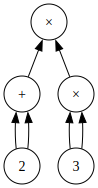

This circuit has size S = 5 and depth d = 2.


In [12]:
from utils import print_header
from arithmetic_circuits import ArithmeticCircuit

eg_count = 2

expression_02 = '(2 + 2)*(3*3)'
ac_02 = ArithmeticCircuit(expression_02, prime=7)

print_header(f"Example {eg_count}\n", level = 2)
print(f"{expression_02} mod {ac_02.field.mod}")
display(ac_02.graphviz_circuit)
print(f"This circuit has size S = {ac_02.size} and depth d = {ac_02.depth}.")

In [13]:
print_header(f"Example {eg_count}\n", level = 2)
ac_02.print_topological_order()

EXAMPLE 2

TOPOLOGICAL ORDERING

2.0 -> 2.1 -> 1.0 -> 1.1 -> 0._


EXAMPLE 2



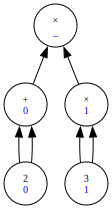

In [14]:
print_header(f"Example {eg_count}\n", level = 2)
display(ac_02.graphviz_circuit_bitstring)

In [15]:
print_header(f"Example {eg_count}\n", level = 2)
ac_02.print_gate_values()

EXAMPLE 2

GATE VALUES

LAYER 2

W_2(0) = 2
W_2(1) = 3

LAYER 1

W_1(0) = 4
W_1(1) = 2

LAYER 0

W_0() = 1



In [16]:
print_header(f"Example {eg_count}\n", level = 2)
ac_02.print_tilde_W()

EXAMPLE 2

MULTLINEAR EXTENSIONS OF GATE-VALUE FUNCTIONS

LAYER 2

W̃_2(x_0) = x_0 + 2

LAYER 1

W̃_1(x_0) = 5*x_0 + 4

LAYER 0

W̃_0() = 1



In [17]:
print_header(f"Example {eg_count}\n", level = 2)
ac_02.print_wiring_predicates()

EXAMPLE 2

ADDITION WIRING PREDICATES (NONZERO VALUES)

LAYER 1

add_1(0,0,0) = 1

LAYER 0


MULTIPLICATION WIRING PREDICATES (NONZERO VALUES)

LAYER 1

mult_1(1,1,1) = 1

LAYER 0

mult_0(0,1) = 1



In [18]:
print_header(f"Example {eg_count}\n", level = 2)
ac_02.print_wiring_predicate_mles()

EXAMPLE 2

MULTLINEAR EXTENSIONS OF WIRING PREDICATES: ADD

LAYER 1

add̃_1(z_0,x_0,y_0) = 6*x_0*y_0*z_0 + x_0*y_0 + x_0*z_0 + 6*x_0 + y_0*z_0 + 6*y_0 + 6*z_0 + 1

LAYER 0

add̃_0(x_0,y_0) = 0

MULTLINEAR EXTENSIONS OF WIRING PREDICATES: MULT

LAYER 1

mult̃_1(z_0,x_0,y_0) = x_0*y_0*z_0

LAYER 0

mult̃_0(x_0,y_0) = 6*x_0*y_0 + y_0



In [19]:
print_header(f"Example {eg_count}\n", level = 2)
ac_02.print_verification_propagation_equation()

EXAMPLE 2

VERIFICATION OF LAYER-WISE GATE-VALUE PROPAGATION EQUATION

LAYER 1

W_1(0) = 4, sum { add_1((0),x,y) [ W_2(x) + W_2(y) ] + mult_1(0,x,y) [ W_2(x) W_2(y)] } over (x,y) in {0,1}^1 × {0,1}^1 = 4 ✓
W_1(1) = 2, sum { add_1((1),x,y) [ W_2(x) + W_2(y) ] + mult_1(1,x,y) [ W_2(x) W_2(y)] } over (x,y) in {0,1}^1 × {0,1}^1 = 2 ✓

LAYER 0

W_0() = 1, sum { add_0((),x,y) [ W_1(x) + W_1(y) ] + mult_0(,x,y) [ W_1(x) W_1(y)] } over (x,y) in {0,1}^0 × {0,1}^0 = 1 ✓



In [20]:
print_header(f"Example {eg_count}\n", level = 2)
ac_02.print_verification_propagation_equation(mle=True)

EXAMPLE 2

VERIFICATION OF THALER'S IDENTITY

LAYER 1

W̃_1(0) = 4, sum { add̃_1((0),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1(0,x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^1 × {0,1}^1 = 4 ✓
W̃_1(1) = 2, sum { add̃_1((1),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1(1,x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^1 × {0,1}^1 = 2 ✓
W̃_1(2) = 0, sum { add̃_1((2),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1(2,x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^1 × {0,1}^1 = 0 ✓
W̃_1(3) = 5, sum { add̃_1((3),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1(3,x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^1 × {0,1}^1 = 5 ✓
W̃_1(4) = 3, sum { add̃_1((4),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1(4,x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^1 × {0,1}^1 = 3 ✓
W̃_1(5) = 1, sum { add̃_1((5),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1(5,x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^1 × {0,1}^1 = 1 ✓
W̃_1(6) = 6, sum { add̃_1((6),x,y) [ W̃_2(x) + W̃_2(y) ] + mult̃_1(6,x,y) [ W̃_2(x) W̃_2(y)] } over (x,y) in {0,1}^1 × {0,1}^1 = 6 ✓

LAYER 0

W̃_0

EXAMPLE 3

Unable to construct gate values or wiring predicates: Node 1.0 in layer 1 does not have at least 2 incoming edges.
Unable to construct multilinear extensions of gate values or wiring predicates: 'ArithmeticCircuit' object has no attribute 'W_dict'.
5*4 + 3 mod 7


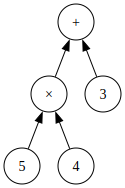

In [21]:
eg_count = 3
print_header(f"Example {eg_count}\n", level = 2)

expression_03a = '5*4 + 3'
expression_03b = '5*4 + (3 + 0)'
ac_03a = ArithmeticCircuit(expression_03a, prime=7)
ac_03b = ArithmeticCircuit(expression_03b, prime=7)

print(f"{expression_03a} mod {ac_03a.field.mod}")
display(ac_03a.graphviz_circuit)

EXAMPLE 3

- The above is not a strictly layered circuit because the input 3 is not in Layer 2 (the depth of the circuit).
- If an arithmetic circuit can't model such a simple computation, it is rather otiose.
- There is a simple workaround: note that 5*4 + 3 = 5*4 + (3 + 0).

5*4 + (3 + 0) mod 7


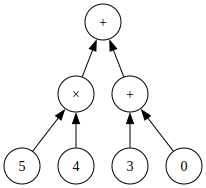

In [22]:
print_header(f"Example {eg_count}\n", level = 2)

print(f"- The above is not a strictly layered circuit because the input 3 is not in Layer {ac_03a.depth} (the depth of the circuit).")
print(f"- If an arithmetic circuit can't model such a simple computation, it is rather otiose.")
print(f"- There is a simple workaround: note that {expression_03a} = {expression_03b}.\n")
print(f"{expression_03b} mod {ac_03b.field.mod}")
display(ac_03b.graphviz_circuit)

EXAMPLE 3

TOPOLOGICAL ORDERING

2.10 -> 2.00 -> 2.01 -> 2.11 -> 1.0 -> 1.1 -> 0._


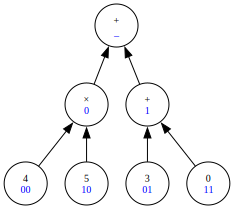

GATE VALUES

LAYER 2

W_2(0,0) = 4
W_2(0,1) = 3
W_2(1,0) = 5
W_2(1,1) = 0

LAYER 1

W_1(0) = 6
W_1(1) = 3

LAYER 0

W_0() = 2

MULTLINEAR EXTENSIONS OF GATE-VALUE FUNCTIONS

LAYER 2

W̃_2(x_0, x_1) = 3*x_0*x_1 + x_0 + 6*x_1 + 4

LAYER 1

W̃_1(x_0) = 4*x_0 + 6

LAYER 0

W̃_0() = 2

ADDITION WIRING PREDICATES (NONZERO VALUES)

LAYER 1

add_1(1,0,1,1,1) = 1

LAYER 0

add_0(0,1) = 1

MULTIPLICATION WIRING PREDICATES (NONZERO VALUES)

LAYER 1

mult_1(0,1,0,0,0) = 1

LAYER 0


MULTLINEAR EXTENSIONS OF WIRING PREDICATES: ADD

LAYER 1

add̃_1(z_0,x_0,x_1,y_0,y_1) = 6*x_0*x_1*y_0*y_1*z_0 + x_1*y_0*y_1*z_0

LAYER 0

add̃_0(x_0,y_0) = 6*x_0*y_0 + y_0

MULTLINEAR EXTENSIONS OF WIRING PREDICATES: MULT

LAYER 1

mult̃_1(z_0,x_0,x_1,y_0,y_1) = x_0*x_1*y_0*y_1*z_0 + 6*x_0*x_1*y_0*y_1 + 6*x_0*x_1*y_0*z_0 + x_0*x_1*y_0 + 6*x_0*x_1*y_1*z_0 + x_0*x_1*y_1 + x_0*x_1*z_0 + 6*x_0*x_1 + 6*x_0*y_0*y_1*z_0 + x_0*y_0*y_1 + x_0*y_0*z_0 + 6*x_0*y_0 + x_0*y_1*z_0 + 6*x_0*y_1 + 6*x_0*z_0 + x_0

LAYER 0

mult̃_0(x_0,y

In [23]:
print_header(f"Example {eg_count}\n", level = 2)

ac_03b.print_topological_order()
display(ac_03b.graphviz_circuit_bitstring)
ac_03b.print_gate_values()
ac_03b.print_tilde_W()
ac_03b.print_wiring_predicates()
ac_03b.print_wiring_predicate_mles()
ac_03b.print_verification_propagation_equation()
ac_03b.print_verification_propagation_equation(mle=True)

EXAMPLE 4

Unable to construct gate values or wiring predicates: invalid literal for int() with base 10: 'x'
Unable to construct multilinear extensions of gate values or wiring predicates: 'ArithmeticCircuit' object has no attribute 'W_dict'.
Unable to construct gate values or wiring predicates: invalid literal for int() with base 10: 'x'
Unable to construct multilinear extensions of gate values or wiring predicates: 'ArithmeticCircuit' object has no attribute 'W_dict'.
5*x + (3*4) mod 7


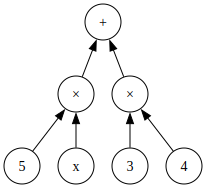

In [24]:
eg_count = 4
print_header(f"Example {eg_count}\n", level = 2)

expression_04 = '5*x + (3*4)'
ac_04 = ArithmeticCircuit(expression_04, prime=7)
ac_03b = ArithmeticCircuit(expression_04, prime=7)

print(f"{expression_04} mod {ac_04.field.mod}")
display(ac_04.graphviz_circuit)

In [25]:
print_header(f"Example {eg_count}\n", level = 2)

print(f"- The above is not a constant-input circuit because the input x a variable.")
print(f"- Nevertheless, we can still explore the arithmetic circuit.")

EXAMPLE 4

- The above is not a constant-input circuit because the input x a variable.
- Nevertheless, we can still explore the arithmetic circuit.


EXAMPLE 4

TOPOLOGICAL ORDERING

2.10 -> 2.11 -> 2.01 -> 2.00 -> 1.0 -> 1.1 -> 0._


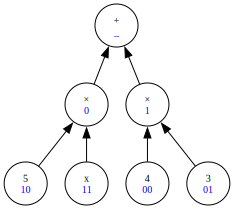

{0: {'0._'}, 1: {'1.1', '1.0'}, 2: {'2.01', '2.00', '2.10', '2.11'}}


In [26]:
print_header(f"Example {eg_count}\n", level = 2)
ac_04.print_topological_order()
display(ac_04.graphviz_circuit_bitstring)
print(ac_04.layers)

EXAMPLE 5

Here is an example of matrix multiplication: [ [1 2] [3 4] ] * [ [5] [6] ] 
1*5 + 2*6 mod 43, 3*5 + 4*6 mod 43


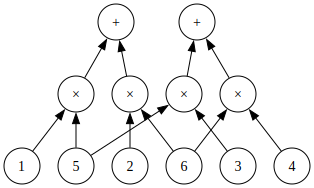

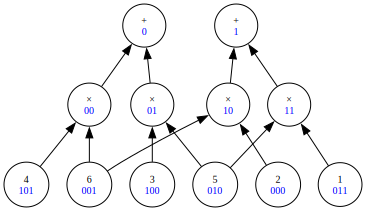

TOPOLOGICAL ORDERING

2.011 -> 2.010 -> 2.000 -> 2.001 -> 2.100 -> 2.101 -> 1.11 -> 1.10 -> 1.01 -> 1.00 -> 0.1 -> 0.0


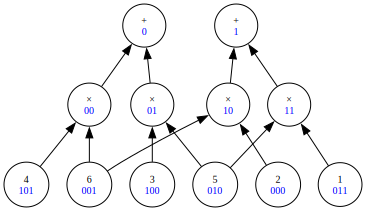

GATE VALUES

LAYER 2

W_2(0,0,0) = 2
W_2(0,0,1) = 6
W_2(0,1,0) = 5
W_2(0,1,1) = 1
W_2(1,0,0) = 3
W_2(1,0,1) = 4
W_2(1,1,0) = 0
W_2(1,1,1) = 0

LAYER 1

W_1(0,0) = 24
W_1(0,1) = 15
W_1(1,0) = 12
W_1(1,1) = 5

LAYER 0

W_0(0) = 39
W_0(1) = 17

MULTLINEAR EXTENSIONS OF GATE-VALUE FUNCTIONS

LAYER 2

W̃_2(x_0, x_1, x_2) = 7*x_0*x_1*x_2 + 37*x_0*x_1 + 40*x_0*x_2 + x_0 + 35*x_1*x_2 + 3*x_1 + 4*x_2 + 2

LAYER 1

W̃_1(x_0, x_1) = 2*x_0*x_1 + 31*x_0 + 34*x_1 + 24

LAYER 0

W̃_0(x_0) = 21*x_0 + 39

ADDITION WIRING PREDICATES (NONZERO VALUES)

LAYER 1


LAYER 0

add_0(0,0,1,0,0) = 1
add_0(1,1,1,1,0) = 1

MULTIPLICATION WIRING PREDICATES (NONZERO VALUES)

LAYER 1

mult_1(0,0,1,0,1,0,0,1) = 1
mult_1(0,1,1,0,0,0,1,0) = 1
mult_1(1,0,0,0,0,0,0,1) = 1
mult_1(1,1,0,1,1,0,1,0) = 1

LAYER 0


MULTLINEAR EXTENSIONS OF WIRING PREDICATES: ADD

LAYER 1

add̃_1(z_0,z_1,x_0,x_1,x_2,y_0,y_1,y_2) = 0

LAYER 0

add̃_0(z_0,x_0,x_1,y_0,y_1) = 42*x_0*x_1*y_0*y_1 + x_0*x_1*y_0 + 42*x_0*x_1*y_1*z_0 + x_0*x_1*y_1 + x_0*

In [10]:
eg_count = 5

print_header(f"Example {eg_count}\n", level = 2)

expression_05a = '1*5 + 2*6'
expression_05b = '3*5 + 4*6'
ac_05 = ArithmeticCircuit(expression_05a, expression_05b, prime=43)

print(f"Here is an example of matrix multiplication: [ [1 2] [3 4] ] * [ [5] [6] ] ")

print(f"{expression_05a} mod {ac_05.field.mod}, {expression_05b} mod {ac_05.field.mod}")
display(ac_05.graphviz_circuit)
display(ac_05.graphviz_circuit_bitstring)
ac_05.print_topological_order()
display(ac_05.graphviz_circuit_bitstring)
ac_05.print_gate_values()
ac_05.print_tilde_W()
ac_05.print_wiring_predicates()
ac_05.print_wiring_predicate_mles()
# With prime field of size p = 43, there will be a large number of equations to print, so we just verify for a random selection
ac_05.print_verification_propagation_equation(random_selection=10)
ac_05.print_verification_propagation_equation(mle=True, random_selection=10)

<a id='appendix_b'></a>
## Appendix B: graph theory
↑↑ [Contents](#contents) ↑ [Appendix a: further examples](#appendix_a)